In [0]:
import numpy as np
import pandas as pd

from fbprophet import Prophet
from sklearn.metrics import mean_absolute_error as mae
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric

import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
df = pd.read_csv('input/visits.csv', parse_dates=['published'], index_col='published')
df.head()

,post_id
published,
2008-01-01 18:19:00,18284
2008-01-01 18:30:00,18285
2008-01-01 18:34:00,18286
2008-01-02 01:32:00,18291
2008-01-02 14:34:00,18294


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 134137 entries, 2008-01-01 18:19:00 to 2016-10-31 23:56:00
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   post_id  134137 non-null  int64
dtypes: int64(1)
memory usage: 2.0 MB


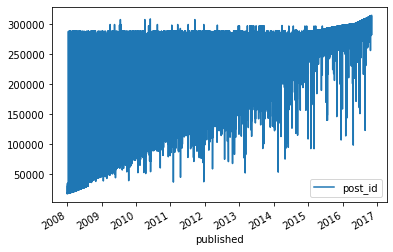

In [0]:
df.plot();

In [0]:
#  How many articles were created per year
df.resample('1Y').count()

,post_id
published,
2008-12-31,7743
2009-12-31,10783
2010-12-31,13091
2011-12-31,15063
2012-12-31,15972
2013-12-31,15537
2014-12-31,16180
2015-12-31,23452
2016-12-31,16316


In [0]:
#  How many articles were created per month
df.resample('1M').count()

,post_id
published,
2008-01-31,435
2008-02-29,496
2008-03-31,545
2008-04-30,597
2008-05-31,635
...,...
2016-06-30,1498
2016-07-31,1278
2016-08-31,1278


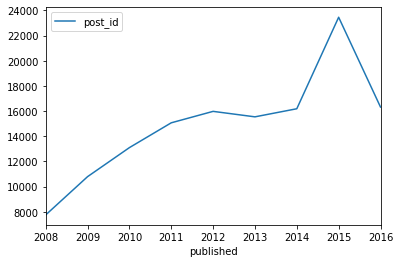

In [0]:
df.resample('1Y').count().plot();

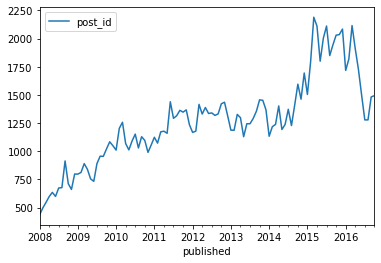

In [0]:
df.resample('1M').count().plot();

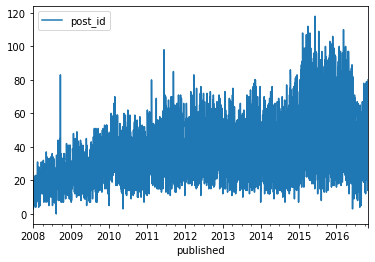

In [0]:
df.resample('1D').count().plot();

In [0]:
df.head()

,post_id
published,
2008-01-01 18:19:00,18284
2008-01-01 18:30:00,18285
2008-01-01 18:34:00,18286
2008-01-02 01:32:00,18291
2008-01-02 14:34:00,18294


In [0]:
df_day = df.resample('1D').count().reset_index()
df_day.columns = ['ds', 'y']

df_day

,ds,y
0,2008-01-01,3
1,2008-01-02,3
2,2008-01-03,4
3,2008-01-04,14
4,2008-01-05,4
...,...,...
3222,2016-10-27,58
3223,2016-10-28,53
3224,2016-10-29,14
3225,2016-10-30,27


# **Forecasting 30 points ahead**

In [0]:
num_points_to_pred = 30

#  Points from the beginning without the last 30 points from the end
train = df_day[:-num_points_to_pred]
#  Points from last 30 points from the end
test = df_day[-num_points_to_pred:]

In [0]:
m = Prophet(changepoint_prior_scale=0.1)
m.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [0]:
future = m.make_future_dataframe(periods=num_points_to_pred, freq='D', include_history=True)
future

,ds
0,2008-01-01
1,2008-01-02
2,2008-01-03
3,2008-01-04
4,2008-01-05
...,...
3222,2016-10-27
3223,2016-10-28
3224,2016-10-29
3225,2016-10-30


In [0]:
forecast = m.predict(future)

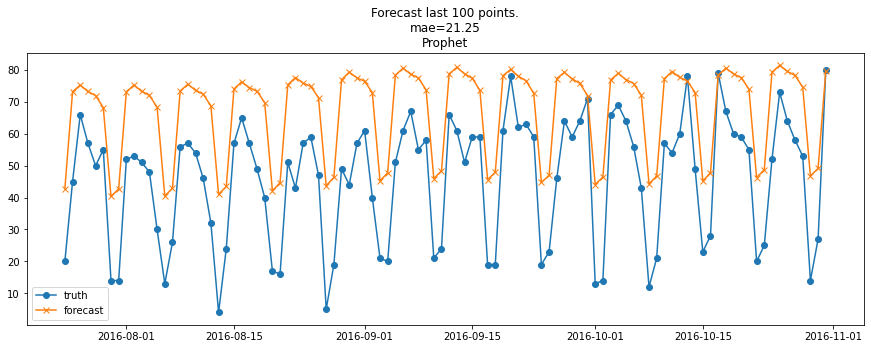

In [0]:
def plot_forecast(test, forecast):
  forecast = forecast[-num_points_to_pred:]
  score = np.round( mae(test.y, forecast.yhat), 2)

  plt.figure(figsize=(15, 5))
  plt.title('Forecast last {} points.\nmae={}\nProphet'.format(num_points_to_pred, score))
  plt.plot(test.ds, test.y, 'o-', label='truth')
  plt.plot(test.ds, forecast.yhat, 'x-', label='forecast')
  plt.legend();

plot_forecast(test, forecast)

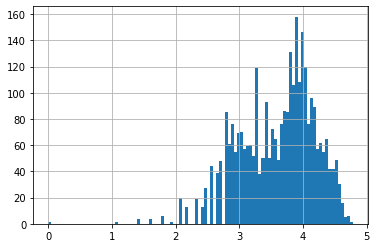

In [0]:
np.log1p(train.y).hist(bins=100);

# **Forecasting 100 points ahead**

In [0]:
num_points_to_pred = 100

#  Points from the beginning without the last 30 points from the end
train = df_day[:-num_points_to_pred]
#  Points from last 30 points from the end
test = df_day[-num_points_to_pred:]

#  Logarithm of values
train_log = train.copy()
train_log['y'] = np.log1p( train_log['y'] )

In [0]:
m = Prophet(changepoint_prior_scale=0.1)
m.fit(train_log)
future = m.make_future_dataframe(periods=num_points_to_pred, \
                                 freq='D', include_history=False)  

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [0]:
forecast = m.predict(future)
forecast['yhat'] = np.expm1( forecast.yhat )

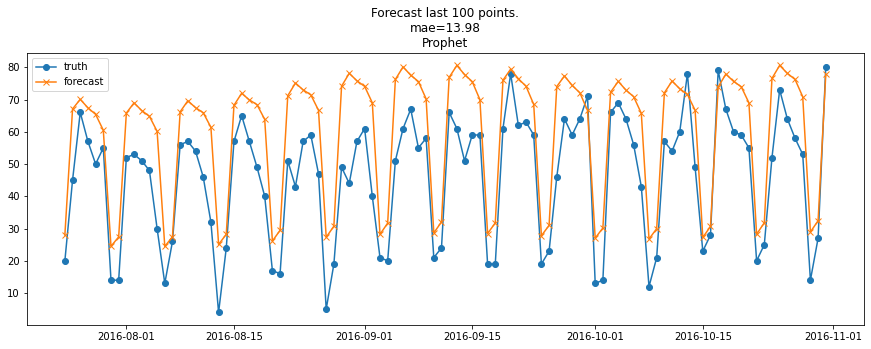

In [0]:
plot_forecast(test, forecast)

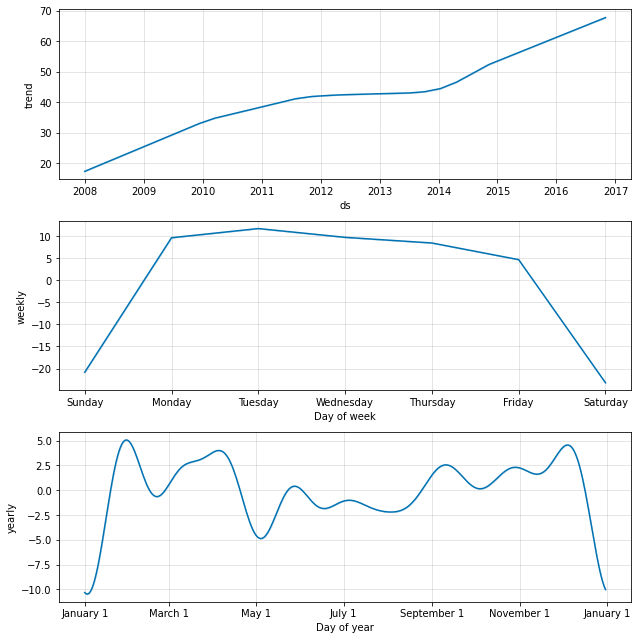

In [0]:
m.plot_components(forecast);

# **Cross-validation**

In [0]:
len(train), len(test)

(3127, 100)

In [0]:
#  period - shift step,  horizon - forecasting forward for a given number of days
df_cv = cross_validation(m, initial='2500 days', period='10 days', horizon='30 days')

INFO:fbprophet:Making 60 forecasts with cutoffs between 2014-11-11 00:00:00 and 2016-06-23 00:00:00


In [0]:
#  number of days forecasted
df_cv.shape

(2010, 6)

In [0]:
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2014-11-12,52.398665,40.725744,63.333050,75,2014-11-11
1,2014-11-13,51.135341,39.816951,62.364469,72,2014-11-11
2,2014-11-14,48.724733,37.145407,59.182547,60,2014-11-11
3,2014-11-15,25.671027,14.039209,37.008218,20,2014-11-11
4,2014-11-16,26.743300,14.896711,38.832152,26,2014-11-11
...,...,...,...,...,...,...
2005,2016-09-27,73.230752,58.132489,87.092486,64,2016-09-01
2006,2016-09-28,71.154727,55.148055,85.128018,59,2016-09-01
2007,2016-09-29,69.736696,55.019210,84.150130,64,2016-09-01
2008,2016-09-30,65.826579,50.943239,80.624976,71,2016-09-01


In [0]:
#  30 days forecasting, 10 points forward and 30 days forecasting again
df_cv.groupby('cutoff').count()

,ds,yhat,yhat_lower,yhat_upper,y
cutoff,,,,,
2014-11-11,30,30,30,30,30
2014-11-21,30,30,30,30,30
2014-12-01,30,30,30,30,30
2014-12-11,30,30,30,30,30
2014-12-21,30,30,30,30,30
...,...,...,...,...,...
2016-07-23,30,30,30,30,30
2016-08-02,30,30,30,30,30
2016-08-12,30,30,30,30,30


## **Metrics of success**

In [0]:
performance_metrics(df_cv)

,horizon,mse,rmse,mae,mape,mdape,coverage
0,3 days,370.880636,19.258261,16.290693,0.564985,0.237616,0.417910
1,4 days,335.711357,18.322428,15.725948,0.435991,0.230491,0.417910
2,5 days,347.337215,18.636985,15.837603,0.477355,0.237049,0.447761
3,6 days,350.526290,18.722347,15.645785,0.460709,0.239833,0.477612
4,7 days,378.171895,19.446642,16.192848,0.468657,0.251411,0.452736
5,8 days,369.704813,19.227710,15.850465,0.437131,0.252164,0.472637
6,9 days,360.750587,18.993435,15.729791,0.436257,0.252077,0.462687
7,10 days,403.976353,20.099163,16.484744,0.472290,0.252164,0.447761
8,11 days,417.601795,20.435308,16.723957,0.585816,0.242194,0.437811
9,12 days,424.907083,20.613274,17.236055,0.588839,0.253703,0.402985


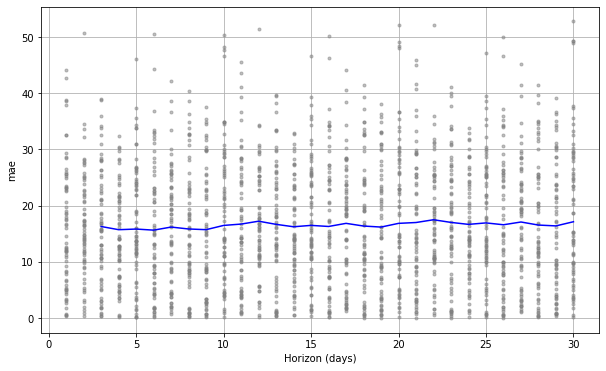

In [0]:
plot_cross_validation_metric(df_cv, 'mae');

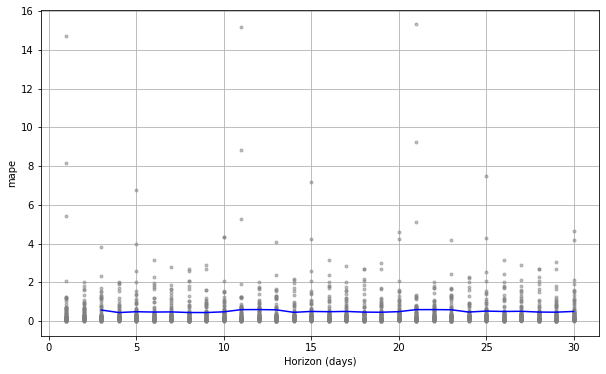

In [0]:
plot_cross_validation_metric(df_cv, 'mape');